# Kaggle 신용카드 사기 탐지를 위한 classification (w/ imbalanced data)  
* 데이터 출처  
https://www.kaggle.com/mlg-ulb/creditcardfraud  (V16 이후 컬럼은 삭제)
* upsampling / downsampling 출처  
https://shinminyong.tistory.com/34  

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 데이터 준비 + 탐색 + 전처리

In [2]:
# 데이터 불러오기
data = pd.read_csv('example_data/creditcard_part.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,69.99,0


<AxesSubplot:xlabel='Class', ylabel='count'>

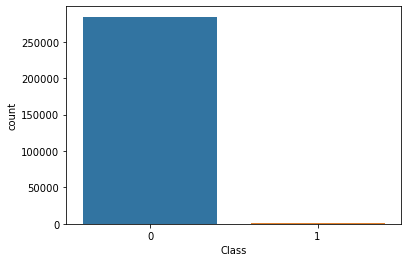

In [3]:
# class 시각화

sns.countplot(x='Class', data=data)

In [12]:
# 차이가 매우 커서 시각화로는 명확한 확인이 어려우므로, 확인
# Series.value_counts()

print(data['Class'].value_counts()) # Series.value_counts() 의 리턴값은 array
print("----> 클래스 1과 클래스 0의 차이는 1:{} 비율만큼 불균형함".format(int(sorted(data['Class'].value_counts())[1]/sorted(data['Class'].value_counts())[0])))

0    284315
1       492
Name: Class, dtype: int64
----> 클래스 1과 클래스 0의 차이는 1:577 비율만큼 불균형함


In [14]:
# np.bincount 활용

class_0, class_1 = np.bincount(data['Class'])
total = class_0 + class_1
print("----> 전체 {}개의 데이터 중, class 0의 개수는 {} + class 1의 개수는 {}".format(total, class_0, class_1))

----> 전체 284807개의 데이터 중, class 0의 개수는 284315 + class 1의 개수는 492


/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

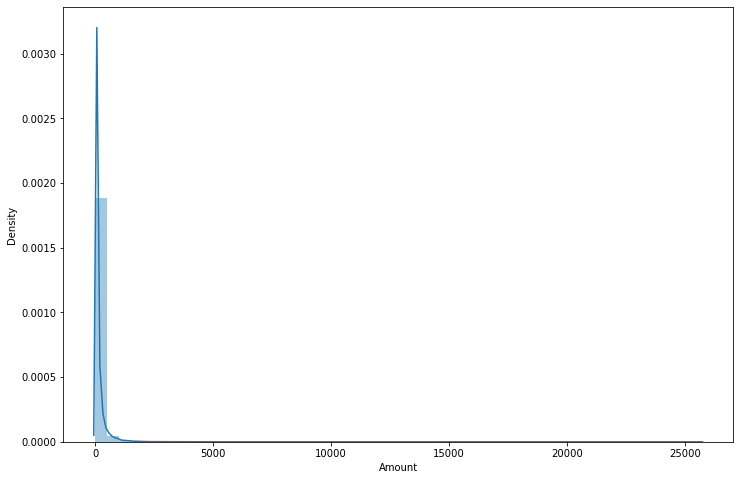

In [18]:
# Amount 분포 시각화

mpl.rcParams['figure.figsize'] = (12, 8)
sns.distplot(data['Amount'])

/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_Amount', ylabel='Density'>

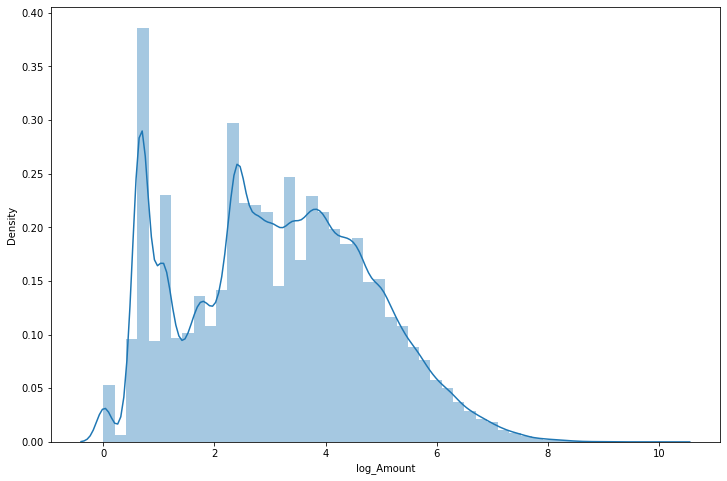

In [19]:
# 불균형 확인 -> 로그화

data['log_Amount'] = np.log1p(data['Amount'])
sns.distplot(data['log_Amount'])

<AxesSubplot:xlabel='log_Amount', ylabel='Class'>

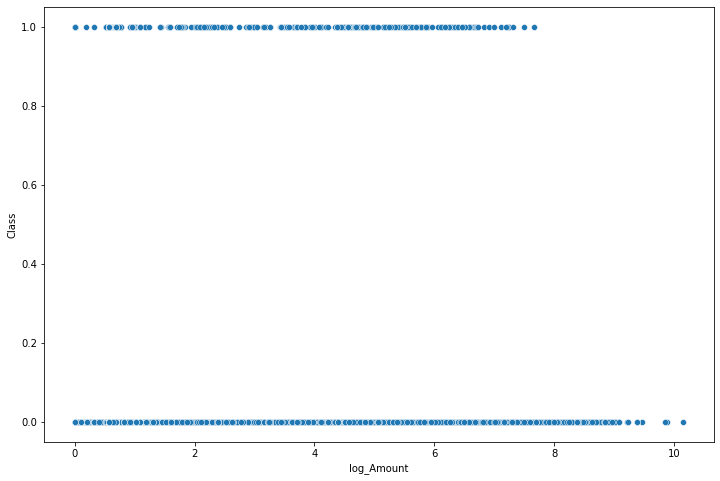

In [22]:
sns.scatterplot(x='log_Amount', y='Class', data=data)

<AxesSubplot:xlabel='Amount', ylabel='Class'>

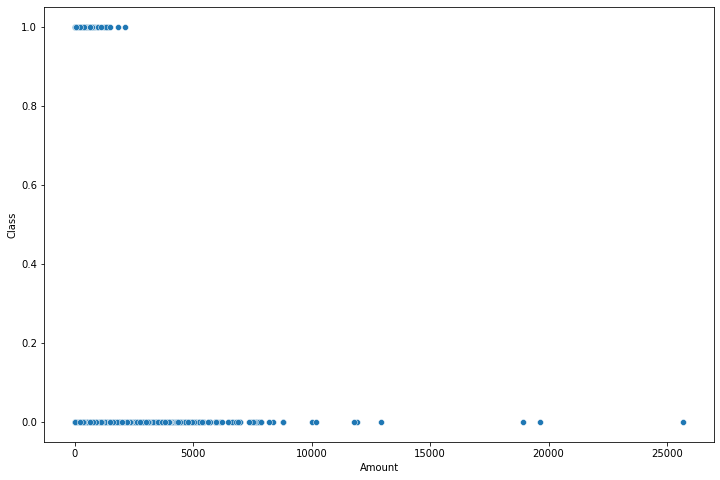

In [23]:
sns.scatterplot(x='Amount', y='Class', data=data)

In [31]:
# 임의로 컬럼 선택
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'Amount', 'log_Amount','Class']
df = data[cols]
df.head()

,V1,V2,V3,V4,V5,Amount,log_Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,149.62,5.014760,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,2.69,1.305626,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,378.66,5.939276,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,123.50,4.824306,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,69.99,4.262539,0


In [32]:
# 결측치 확인

df.isnull().sum()

V1            0
V2            0
V3            0
V4            0
V5            0
Amount        0
log_Amount    0
Class         0
dtype: int64

<AxesSubplot:xlabel='log_Amount', ylabel='Class'>

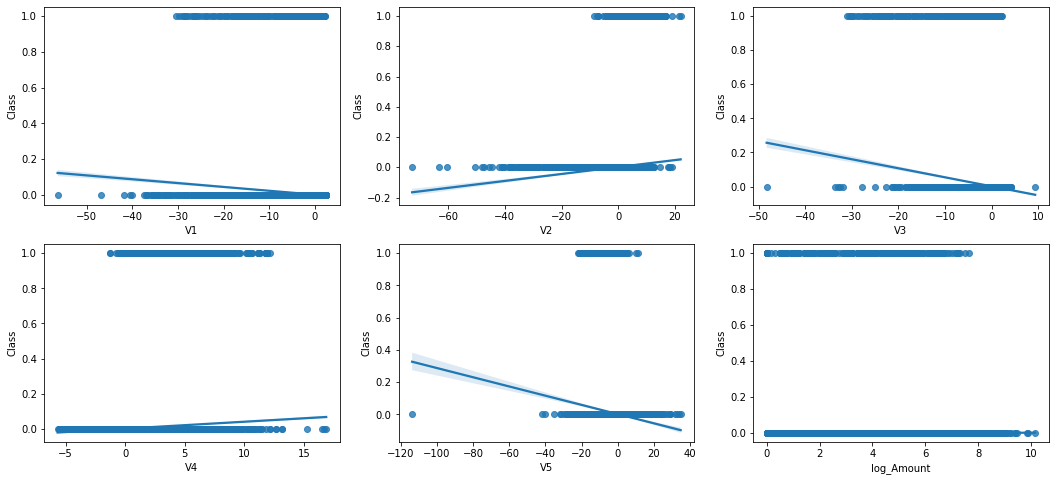

In [35]:
# 시각화 (산점도)

figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

sns.regplot(x='V1', y='Class', data=df, ax=ax1)
sns.regplot(x='V2', y='Class', data=df, ax=ax2)
sns.regplot(x='V3', y='Class', data=df, ax=ax3)
sns.regplot(x='V4', y='Class', data=df, ax=ax4)
sns.regplot(x='V5', y='Class', data=df, ax=ax5)
sns.regplot(x='log_Amount', y='Class', data=df, ax=ax6)

/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

<AxesSubplot:xlabel='log_Amount', ylabel='Density'>

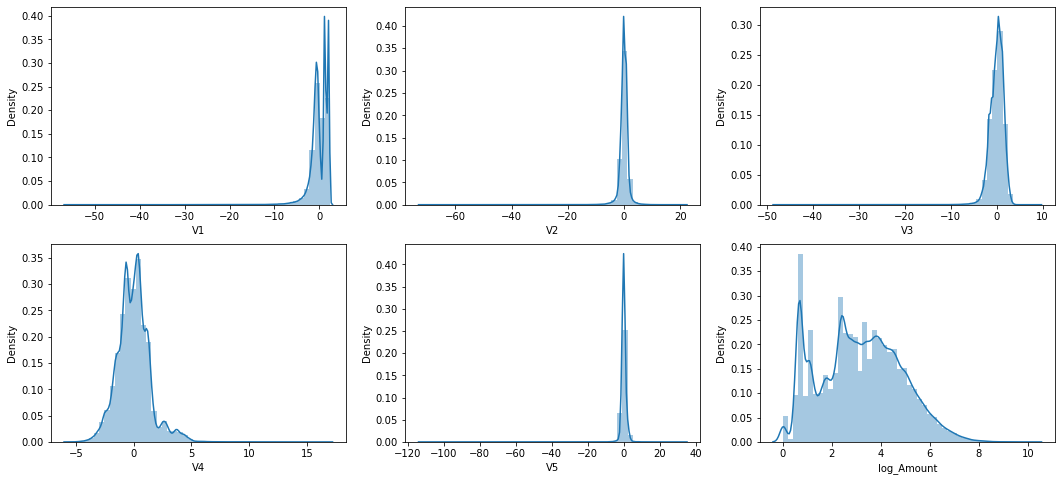

In [37]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

sns.distplot(df['V1'], ax=ax1)
sns.distplot(df['V2'], ax=ax2)
sns.distplot(df['V3'], ax=ax3)
sns.distplot(df['V4'], ax=ax4)
sns.distplot(df['V5'], ax=ax5)
sns.distplot(df['log_Amount'], ax=ax6)

### 차원축소 (PCA)
* 출처 : https://rladuddms.tistory.com/4

In [56]:
# PCA 는 속성의 영향을 받으므로 스케일링을 해줘야 함

from sklearn.preprocessing import StandardScaler

df_scaled = StandardScaler().fit_transform(df)

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scaled)
pca_result = pca.transform(df_scaled)

pca_cols = ['pca1', 'pca2']
df_pca = pd.DataFrame(pca_result, columns=pca_cols)
df_pca['Class'] = data['Class']
df_pca.head()

,pca1,pca2,Class
0,0.795144,-0.435222,0
1,-0.982726,0.049263,0
2,2.059362,-0.678659,0
3,0.576704,-0.823166,0
4,0.143798,-0.148782,0


/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pca2', ylabel='Density'>

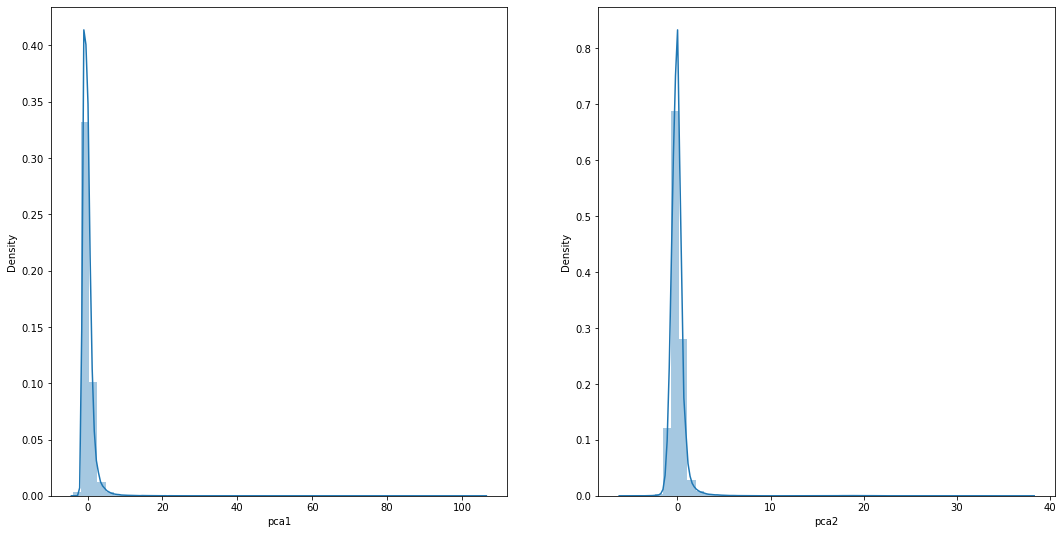

In [60]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,9))

sns.distplot(df_pca['pca1'], ax=ax1)
sns.distplot(df_pca['pca2'], ax=ax2)

### 데이터셋 분리

In [61]:
# train / test 분리

from sklearn.model_selection import train_test_split

x_cols = ['pca1', 'pca2']
y_col = 'Class'

X_train, X_test, y_train, y_test = train_test_split(df_pca[x_cols], 
df_pca[y_col], 
test_size=0.2, 
random_state=0,
stratify=df_pca[y_col])

In [64]:
print("train: ", len(X_train), " , test: ", len(X_test))

train:  227845  , test:  56962


In [67]:
class_0, class_1 = np.bincount(y_train)
total = class_0 + class_1
print("y_train -> 전체 {}개의 데이터 중, class 0의 개수는 {} + class 1의 개수는 {}. 1: {}".format(total, class_0, class_1, int(class_0/class_1)))

y_train -> 전체 227845개의 데이터 중, class 0의 개수는 227451 + class 1의 개수는 394. 1: 577


In [68]:
class_0, class_1 = np.bincount(y_test)
total = class_0 + class_1
print("y_test -> 전체 {}개의 데이터 중, class 0의 개수는 {} + class 1의 개수는 {}. 1: {}".format(total, class_0, class_1, int(class_0/class_1)))

y_test -> 전체 56962개의 데이터 중, class 0의 개수는 56864 + class 1의 개수는 98. 1: 580


### Upsampling / Downsapling